In [1]:
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

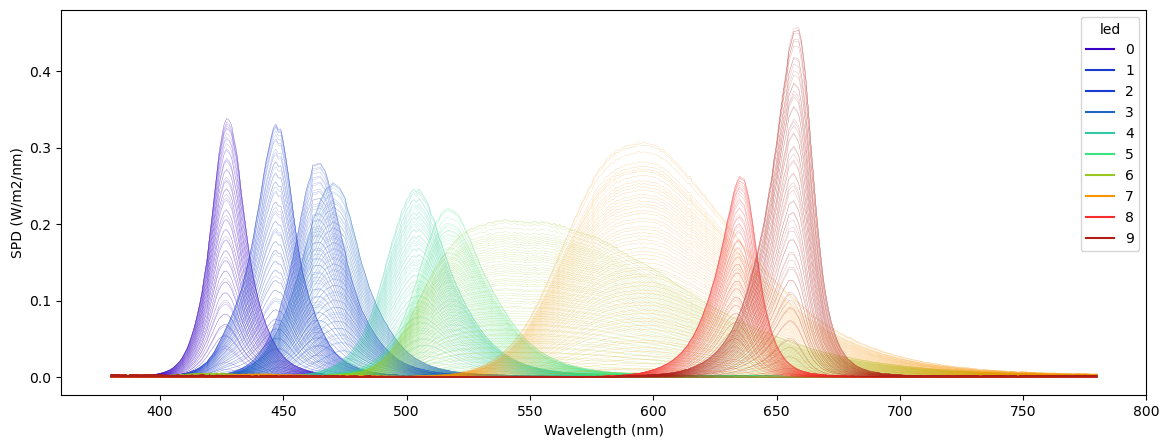

In [2]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [3]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [4]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


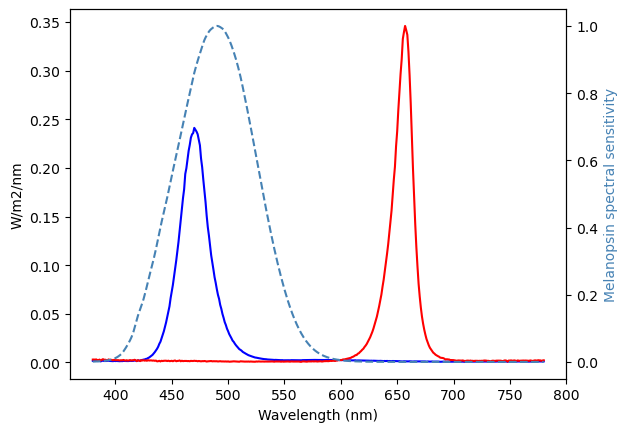

In [5]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [6]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity



Please enter subject ID: 001
> Grabbing 65 seconds of pupil.1.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 774699.631959
> Waiting for a light to stamp...
> Light stamped on frame.world at 774711.107787
> Waiting for a light to stamp...
> Light stamped on frame.world at 774722.691951
> Waiting for a light to stamp...
> Light stamped on frame.world at 774734.0879960001
> Waiting for a light to stamp...
> Light stamped on frame.world at 774745.722192
> Waiting for a light to stamp...
> Light stamped on frame.world at 774757.1960540001
> PupilGrabber done grabbing 65 seconds of pupil.1.3d


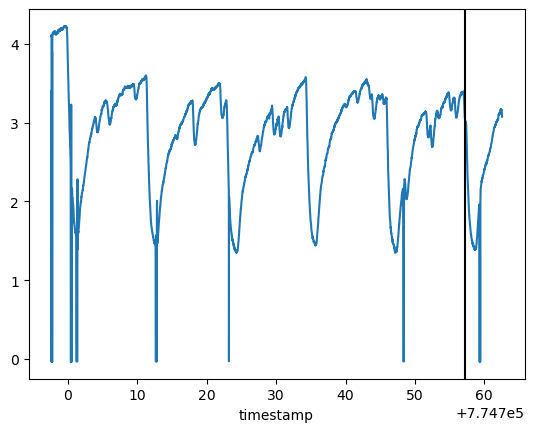

In [10]:
# PIPR STIMS - USE THIS ONE
from time import sleep
import random
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir

subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 60 # interstimulus time, in seconds
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 30 # approrpaite offset to account for stim duration + sleeps

# Connect to Pupil Core
p = PupilCore()

# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=65) # time here is TOTAL run time
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(10.) # change to 60-120 or set to ISI
    # sleep(ISI)
##################################

# Wait for the futures
while lst_future.running() or pgr_future.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data = unpack_data_pandas(pgr_future.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax = data['diameter_3d'].plot()
ax.axvline(x=timestamp, color='k')

In [11]:
# display data from pandas table
data

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
774697.569441,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.22518402088470402, 0.6202226820463324]",59.343144,0.882838,"{'center': [1.0074978286098688, -0.58287587739...","{'center': [104.87058477468739, 90.73169584321...","{'center': [-4.412033516400508, -0.45636156222...",4.103214,"{'center': [43.23533200986317, 72.917245047104...","[43.23533200986317, 72.91724504710417]",1.0,1.558622,-2.119443
774697.585572,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.22574063967294025, 0.6216388182709265]",59.447402,0.892030,"{'center': [1.0074978286098688, -0.58287587739...","{'center': [104.87058477468739, 90.73169584321...","{'center': [-4.40844288188469, -0.475148693207...",4.110257,"{'center': [43.34220281720453, 72.645346891982...","[43.34220281720453, 72.64534689198211]",1.0,1.560430,-2.119026
774697.604766,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.22863709326436032, 0.6240430069714489]",59.112086,0.876117,"{'center': [1.0074978286098688, -0.58287587739...","{'center': [104.87058477468739, 90.73169584321...","{'center': [-4.357943812337626, -0.50177498529...",4.085160,"{'center': [43.89832190675718, 72.183742661481...","[43.89832190675718, 72.18374266148182]",1.0,1.562992,-2.113328
774697.622238,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.23219089606763058, 0.6257820335491258]",58.967227,0.867614,"{'center': [1.0074978286098688, -0.58287587739...","{'center': [104.87058477468739, 90.73169584321...","{'center': [-4.308391249311185, -0.51809712322...",4.072421,"{'center': [44.58065204498507, 71.849849558567...","[44.58065204498507, 71.84984955856787]",1.0,1.564563,-2.107763
774697.638693,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.5763801987029186, 0.5453627498686713]",0.000002,0.000000,"{'center': [1.0074978286098688, -0.58287587739...","{'center': [104.87058477468739, 90.73169584321...","{'center': [1.0802257550811512, -0.62645707981...",-0.037152,"{'center': [110.66499815096037, 87.29035202521...","[110.66499815096037, 87.29035202521513]",0.1,1.574990,-1.563798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774762.499249,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.2275611405059972, 0.6944532035233213]",46.538767,1.000000,"{'center': [1.3797724548545962, -0.38075866933...","{'center': [108.39691537179047, 92.47786870470...","{'center': [-4.394487664042412, -3.18567115316...",3.163180,"{'center': [43.691738977151466, 58.66498492352...","[43.691738977151466, 58.664984923522304]",1.0,1.844088,-2.185901
774762.515190,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.22742121507267954, 0.694236071679871]",46.172990,1.000000,"{'center': [1.3797724548545962, -0.38075866933...","{'center': [108.39691537179047, 92.47786870470...","{'center': [-4.387626171421985, -3.18615966297...",3.138463,"{'center': [43.66487329395447, 58.706674237464...","[43.66487329395447, 58.70667423746478]",1.0,1.844137,-2.185071
774762.532471,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.22695778582177004, 0.6945598424790497]",45.998637,1.000000,"{'center': [1.3797724548545962, -0.38075866933...","{'center': [108.39691537179047, 92.47786870470...","{'center': [-4.382456466088378, -3.21312509506...",3.127014,"{'center': [43.575894877779845, 58.64451024402...","[43.575894877779845, 58.64451024402246]",1.0,1.846833,-2.184975


In [12]:
import os  

os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

# output the above table to a new csv file, using the path below

data.to_csv('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/001.csv')  

In [29]:
new_data = data[['confidence','id','diameter','diameter_3d']]

In [31]:
samples = new_data
samples

,confidence,id,diameter,diameter_3d
timestamp,,,,
774697.569441,0.882838,1,59.343144,4.103214
774697.585572,0.892030,1,59.447402,4.110257
774697.604766,0.876117,1,59.112086,4.085160
774697.622238,0.867614,1,58.967227,4.072421
774697.638693,0.000000,1,0.000002,-0.037152
...,...,...,...,...
774762.499249,1.000000,1,46.538767,3.163180
774762.515190,1.000000,1,46.172990,3.138463
774762.532471,1.000000,1,45.998637,3.127014


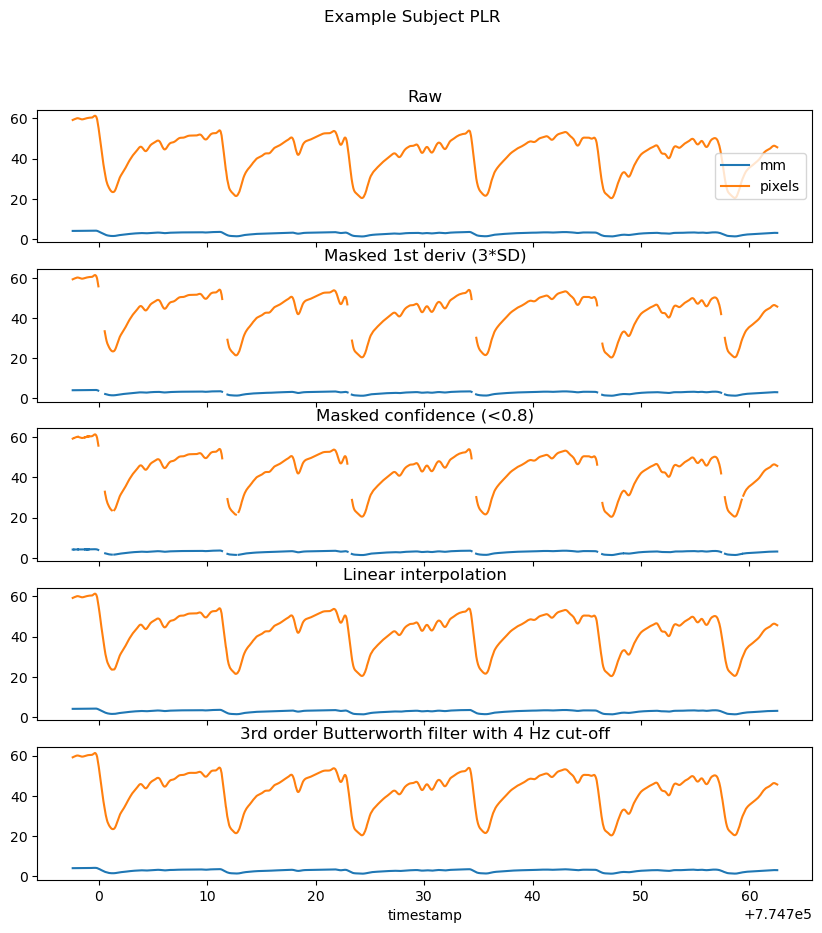

In [40]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [62]:
import pandas as pd
events = pd.Index([774699.631959, 774711.107787, 774722.691951, 774734.0879960001, 774745.722192, 774757.1960540001], name='timestamps')
events.to_series()
DURATION = 1320
ONSET_IDX = 600
# Extract the event ranges
import pandas as pd
from pyplr import utils as utls
events = pd.Index([774699.631959, 774711.107787, 774722.691951, 774734.0879960001, 774745.722192, 774757.1960540001], name='timestamps')
events = events.to_series()
ranges = utls.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])
ranges

AttributeError: 'numpy.float64' object has no attribute 'get'

In [69]:
import pandas as pd
events = pd.Index([774699.631959, 774711.107787, 774722.691951, 774734.0879960001, 774745.722192, 774757.1960540001], name='timestamps')
events.to_series()
DURATION = 1200
ONSET_IDX = 0
# Extract the event ranges
import pandas as pd
from pyplr import utils as utls
from importlib import reload
reload(utls)
events = pd.Index([774699.631959, 774711.107787, 774722.691951, 774734.0879960001, 774745.722192, 774757.1960540001], name='timestamps')
events = events.to_series()
ranges = utls.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])
ranges

IndexError: index 4074 is out of bounds for axis 0 with size 3868

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [109]:
# Read in csv file and extract the column with header "CVR"
df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/001.csv")
# Print header names
print(df_pipr.columns)

# Extract the column with header "CVR"
timestamps = df_pipr["timestamp"]
# Extract the column with header "CVR_SI"
diam_3d = df_pipr["diameter_3d"]

Index(['timestamp', 'id', 'topic', 'method', 'norm_pos', 'diameter',
       'confidence', 'sphere', 'projected_sphere', 'circle_3d', 'diameter_3d',
       'ellipse', 'location', 'model_confidence', 'theta', 'phi'],
      dtype='object')


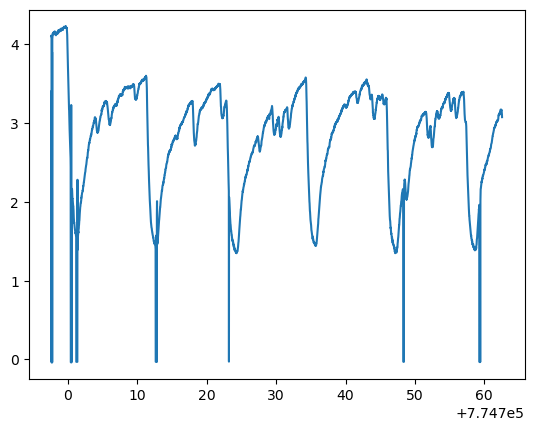

In [110]:
fig = plt.figure()
plt.plot(timestamps, diam_3d)

In [14]:
# for some reason the saved .csv doesn't have the exact timestamps of the light stamper (sampling?)
# this gives the index of the first lightstamp
np.where(timestamps == 774699.604981)

(array([133], dtype=int64),)

In [111]:
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps <= 774699.631959)[0][-1]
stamp2 = np.where(timestamps <= 774711.107787)[0][-1]
stamp3 = np.where(timestamps <= 774722.691951)[0][-1]
stamp4 = np.where(timestamps <= 774734.0879960001)[0][-1]
stamp5 = np.where(timestamps <= 774745.722192)[0][-1]
stamp6 = np.where(timestamps <= 774757.1960540001)[0][-1]
stamps = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps

[134, 817, 1505, 2173, 2874, 3552]

In [112]:
from pyplr import utils
from copy import deepcopy

In [113]:
df_data = df_pipr[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data

,timestamp,confidence,id,diameter,diameter_3d
0,774697.569441,0.882838,1,59.343144,4.103214
1,774697.585572,0.892030,1,59.447402,4.110257
2,774697.604766,0.876117,1,59.112086,4.085160
3,774697.622238,0.867614,1,58.967227,4.072421
4,774697.638693,0.000000,1,0.000002,-0.037152
...,...,...,...,...,...
3863,774762.499249,1.000000,1,46.538767,3.163180
3864,774762.515190,1.000000,1,46.172990,3.138463
3865,774762.532471,1.000000,1,45.998637,3.127014
3866,774762.551368,1.000000,1,45.720631,3.108086


In [114]:
# extract ranges from samples based on event timing and sample count
# adapted from extract() from utils.py
# set variables - change as necessary
samples = df_data
event_starts = stamps[:-1] # only removed the last sample because it was incomplete
onset_time = 1
duration_time = 10
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs = (
    np.searchsorted(samples.index, event_starts, "left") + offset
)
range_duration = duration


In [115]:
range_idxs

array([  74,  757, 1445, 2113, 2814], dtype=int64)

In [116]:
# make a hierarchical index
samples["orig_idx"] = samples.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples):
        end_idx = len(samples) - 1
    new_df = deepcopy(
        samples.loc[samples.index[start_idx] : samples.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df = pd.concat([df, new_df])
    idx += 1
df.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

Extracted ranges for 5 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_4908\2016008756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples["orig_idx"] = samples.index


In [117]:
df.index

MultiIndex([(0,   0),
            (0,   1),
            (0,   2),
            (0,   3),
            (0,   4),
            (0,   5),
            (0,   6),
            (0,   7),
            (0,   8),
            (0,   9),
            ...
            (4, 590),
            (4, 591),
            (4, 592),
            (4, 593),
            (4, 594),
            (4, 595),
            (4, 596),
            (4, 597),
            (4, 598),
            (4, 599)],
           names=['event', 'onset'], length=3000)

In [118]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines = df.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df = preproc.percent_signal_change(
    df, baselines, ['diameter_3d', 'diameter'])
df


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_4908\2404135914.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines = df.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      774698.780005    0.873368   1  59.864776     4.171070        74   
      1      774698.793717    0.875415   1  60.020824     4.173617        75   
      2      774698.807086    0.854207   1  60.036897     4.174290        76   
      3      774698.821558    0.809582   1  60.009219     4.171464        77   
      4      774698.837229    0.827944   1  60.035872     4.174209        78   
...                    ...         ...  ..        ...          ...       ...   
4     595    774754.805098    0.983528   1  49.838135     3.369789      3409   
      596    774754.821162    0.976900   1  50.000602     3.380457      3410   
      597    774754.837354    0.893840   1  49.868292     3.371486      3411   
      598    774754.862096    1.000000   1  50.039318     3.383331      3412   
      599    774754.878131    0.961788   1  49.699446     3.359882      3413   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           -0.583463    -0.914417  
      1           -0.522737    -0.656132  
      2           -0.506707    -0.629528  
      3           -0.574052    -0.675340  
      4           -0.508637    -0.631226  
...                     ...          ...  
4     595          1.890327    -0.692920  
      596          2.212901    -0.369189  
      597          1.941632    -0.632829  
      598          2.299782    -0.292045  
      599          1.590786    -0.969270  

[3000 rows x 8 columns]

In [119]:
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_4908\2953176601.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  average_plr = df.mean(level=1)['diameter_3d'].to_numpy()


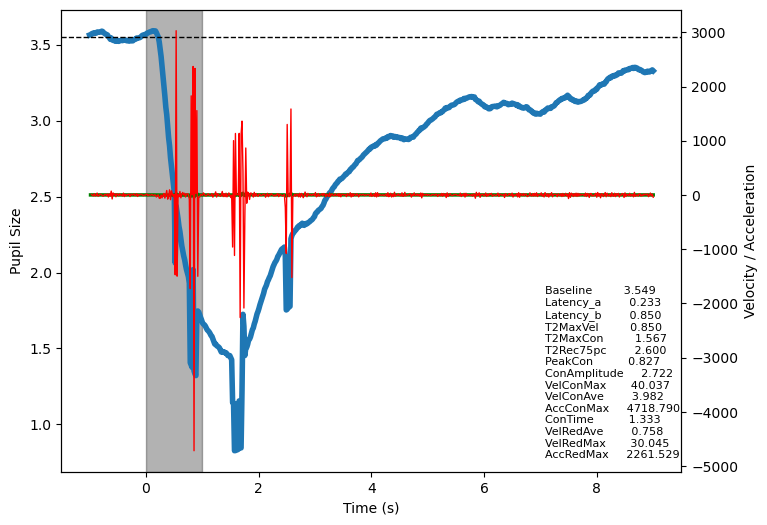

In [120]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [74]:
params = plr.parameters()
params

,value
Baseline,3.548928
Latency_a,0.233333
Latency_b,0.850000
T2MaxVel,0.850000
T2MaxCon,1.566667
T2Rec75pc,2.600000
PeakCon,0.827150
ConAmplitude,2.721779
VelConMax,40.036999
VelConAve,3.982009


In [ ]:
params.to_csv('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/001.csv')  

Text(0.5, 1.0, 'Subject = 1')

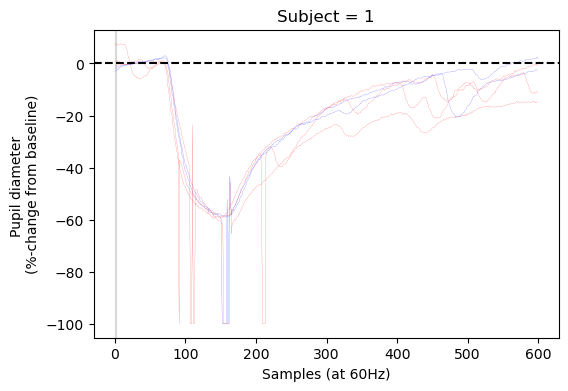

In [121]:
# Plot PIPRs
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'red'
    else:
        c = 'blue'
    df.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)
# TODO: modify timescale so that it shows baseline before 0
# Now show the means
#avgs = (df.reset_index()
            #    .groupby(['color','onset'], as_index=False)
             #   .mean())
#sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='color',
           #     palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Samples (at 60Hz)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df['id'][0][0]))

# Save
#fig.savefig('../img/PIPR_{}.svg'.format(s['id']))

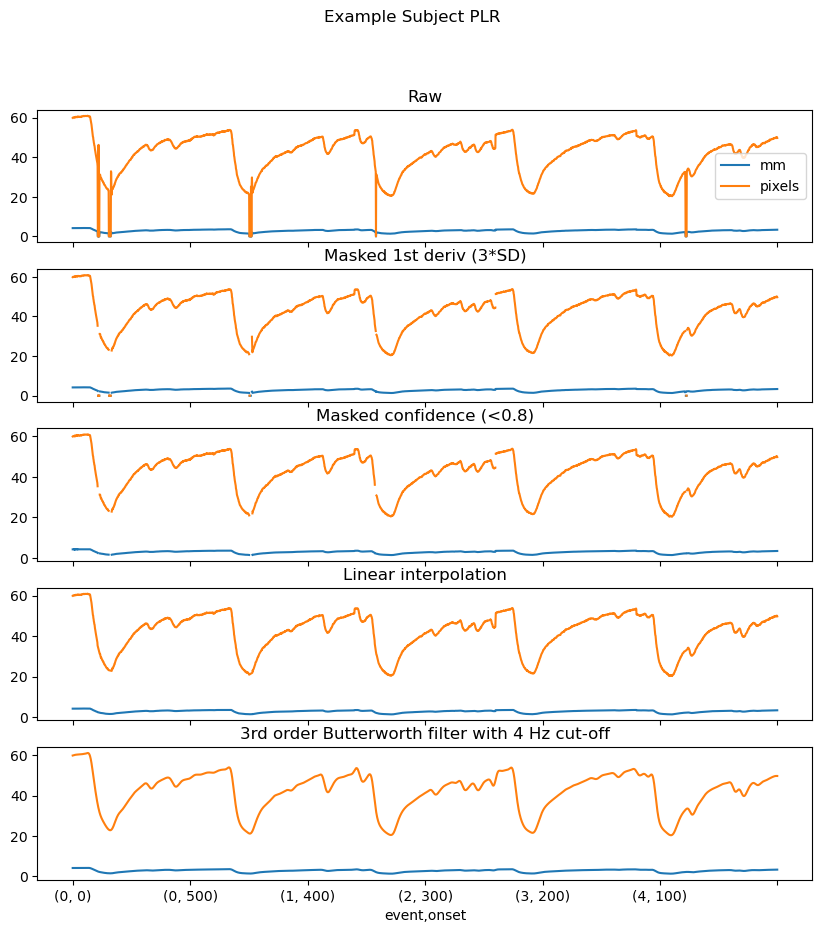

In [122]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples = df

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Example Subject PLR')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [124]:
# Convert samples index-level to time (s)
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df.index = df.index.set_levels(
    levels=new_onset, level='onset')

Text(0.5, 1.0, 'Subject = 1')

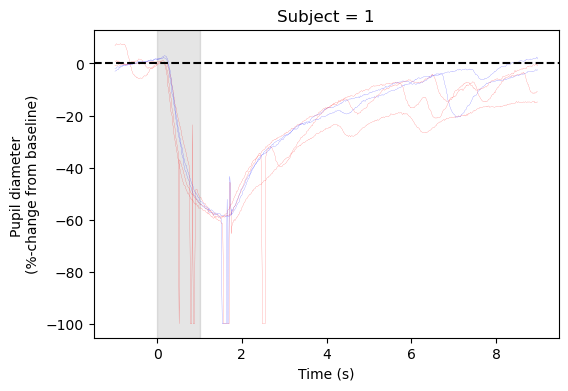

In [126]:
# Plot PIPRs
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'red'
    else:
        c = 'blue'
    df.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)
# TODO: modify timescale so that it shows baseline before 0
# Now show the means
#avgs = (df.reset_index()
            #    .groupby(['color','onset'], as_index=False)
             #   .mean())
#sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='color',
           #     palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df['id'][0][0]))

# Save
#fig.savefig('../img/PIPR_{}.svg'.format(s['id']))

In [128]:
samples

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      774698.780005    0.873368   1  59.859877     4.171063        74   
      1      774698.793717    0.875415   1  59.896882     4.172362        75   
      2      774698.807086    0.854207   1  59.933765     4.173655        76   
      3      774698.821558    0.809582   1  59.970120     4.174934        77   
      4      774698.837229    0.827944   1  60.005583     4.176188        78   
...                    ...         ...  ..        ...          ...       ...   
4     595    774754.805098    0.983528   1  49.750423     3.364294      3409   
      596    774754.821162    0.976900   1  49.750638     3.364077      3410   
      597    774754.837354    0.893840   1  49.747892     3.363674      3411   
      598    774754.862096    1.000000   1  49.742835     3.363133      3412   
      599    774754.878131    0.961788   1  49.736188     3.362506      3413   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0           -0.583463    -0.914417             0  
      1           -0.522737    -0.656132             0  
      2           -0.506707    -0.629528             0  
      3           -0.574052    -0.675340             0  
      4           -0.508637    -0.631226             0  
...                     ...          ...           ...  
4     595          1.890327    -0.692920             0  
      596          2.212901    -0.369189             0  
      597          1.941632    -0.632829             0  
      598          2.299782    -0.292045             0  
      599          1.590786    -0.969270             0  

[3000 rows x 9 columns]

Float64Index([               -1.0, -0.9833333333333333, -0.9666666666666667,
                            -0.95, -0.9333333333333333, -0.9166666666666666,
                             -0.9, -0.8833333333333333, -0.8666666666666667,
                            -0.85,
              ...
                8.833333333333334,                8.85,   8.866666666666667,
                8.883333333333333,                 8.9,   8.916666666666666,
                8.933333333333334,                8.95,   8.966666666666667,
                8.983333333333333],
             dtype='float64', name='onset', length=3000)

In [142]:
df.to_csv('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/001-new.csv')  